# AnomalyDetection_3_Problem_1

**Updates from parent notebook:** 
- this notebook follows the problem definition laid out in AnomalyDetection_2_DefiningProblem
- this notebook deals with the possible solutions presented there
   

## Libraries and Configuration

In [1]:
""" Libraries """

#file / system libraries 
import os
import datetime as dt

# mathematical 

from numpy.fft import ifft
from numpy.fft import fft
import numpy as np

# data exploration

import pandas as pd

# data visualization

import matplotlib.pyplot as plt

""" Configuration """

# pandas 

pd.set_option('display.max_columns', None)

## Functions

In [2]:
def polynomial(x):
    """ takes an array and returns it after our polynomial function has been applied to it"""
    C = [0.7741697399557282,-0.15839741967042406,0.09528795099596377,-0.004279871380772796]
    y = C[0]*np.power(x,4)+C[1]*np.power(x,2)+C[2]*x+C[3]
    return y

def directory_to_df(paths, exclude = [None], filetype = '.csv',ignore_index = True, exception = '_repet'):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    exclude: array of directories to excludes from the treatment
    filetype: a string of the file extension (must include .)
    ignore_index: boolean that tells pandas to ignore the index or not
    exception: takes a string. Any time a filename includes this string it is treated differently (for cases when you have
    more than one ) 
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    
    for path in paths:
        for filename in os.listdir(path):
            print(path)
            if filetype in filename and filename not in exclude:
                if exception in filename:
                    curr_df = pd.read_csv(path+filename)
                    curr_df = special_treatment(curr_df)
                    
                else:
                    curr_df = pd.read_csv(path+filename)                    
                frames.append(curr_df)
                filenames.append(filename.replace(filetype,''))
                for i in range(curr_df.shape[0]):
                    file_column.append(test_index)
                test_index+=1

    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames


def special_treatment(df):
    """ performs a custom operation on a dataframe
    components:
    df: dataframe to play on
    """
    columns = df.columns.values.tolist()
    columns.remove('date')
    df.drop('gyrZ',inplace = True, axis = 1)
    df.columns = columns
    df.reset_index(inplace = True)
    df.rename(columns= {'index':'date'},inplace = True)
    return df

class seasonality():
    """ takes in a dataframe, outputting it with two extra columns: seasonality (but column name = seasonality
    inputted) and times, where 'times' is a plottable version of date with reference to a prespecified start time
    (day_start)
    Components:
    df: the dataframe, must have the dates column as 'date' and in np.datetime64 timeformat
    seasonality (optional): defaults to 'day'. This is the criteria for splitting the data
    day_start (optional): this signifies what is the 'start time' of the day (i.e. the 0 point on the x axis). Defaults
    for midnight.
    time_delta (optional): this defines the units for the time delta between data points. Defaults to seconds.
    EDIT THIS MSG
    NEED TO FIX THIS
    """ 
    def __init__(self,df,seasonality='day',day_start = '00:00:00', time_delta = 's'):
        
        if seasonality not in ['hour','day','month','year']:
            raise ValueError("you can only input the following for seasonality: 'day', 'month', or 'year'")
        self.df = df
        self.seasonality = 'seasonality_{}'.format(seasonality)
        try:
            self.day_start = dt.datetime.strptime(day_start,'%H:%M:%S')
        except:
            raise ValueError('Please enter your day_start in the correct format: "HH:MM:SS". "{}" is not acceptable'\
                             .format(day_start))
        self.time_delta = time_delta

    def find_seasonal_trends(self):
        if 'hour' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.hour
        elif 'day' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.day
        elif 'month' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.month
        else:
            self.df[self.seasonality] = self.df.date.dt.year
            
        self.create_times()


        return self.df
    
    def create_times(self):
        times = []
        for season in self.df[self.seasonality].unique():
            temp_dates = self.df.date[self.df[self.seasonality] == season].values
            date = dt.datetime.strptime(str(temp_dates[0])[:-3], '%Y-%m-%dT%H:%M:%S.%f')
            # 'date' is wrong: this will not work for when you have a lower order seasonality.
            # it needs to adapt such that it starts recording when the beginning of the year
            start_day = dt.datetime(date.year,
                                    date.month,
                                    date.day,
                                    self.day_start.hour,
                                    self.day_start.minute,
                                    self.day_start.second)
            start_day = np.datetime64(start_day)
            
            for index, date in enumerate(temp_dates):
                times.append((date - start_day)/np.timedelta64(1, self.time_delta))
        self.df['times'] = times

## Data

In [3]:
base = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/{}'
names = ['rohan','ignacio']
end_labels = ['_filtered.csv']
dfs = []

for index,name in enumerate(names):
    dfs.append(pd.read_csv(base.format(names[index]+end_labels[0]),index_col = 0))

In [4]:
dfs[0].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
220,2020-09-14 19:19:26,0.01,0.02,0.00,3.62,1.04,1.38,1,0.022361,4.011284
319,2020-09-14 19:20:39,0.09,0.16,0.14,36.11,25.84,67.85,1,0.230868,81.087978
320,2020-09-14 19:20:40,0.09,0.16,0.09,22.98,15.43,16.45,1,0.204450,32.198879
321,2020-09-14 19:20:41,0.05,0.07,0.09,22.98,15.43,16.45,1,0.124499,32.198879
322,2020-09-14 19:20:42,0.12,0.07,0.07,29.44,39.83,27.27,1,0.155563,56.540210


In [5]:
dfs[1].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
0,2020-09-13 17:09:25,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
1,2020-09-13 17:09:26,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
2,2020-09-13 17:09:27,0.01,0.01,0.00,7.43,6.82,10.10,1,0.014142,14.273307
12,2020-09-13 17:09:34,0.01,0.01,0.00,6.64,7.07,12.45,1,0.014142,15.782173
13,2020-09-13 17:09:34,0.01,0.01,0.00,4.12,3.61,5.81,1,0.014142,7.985149


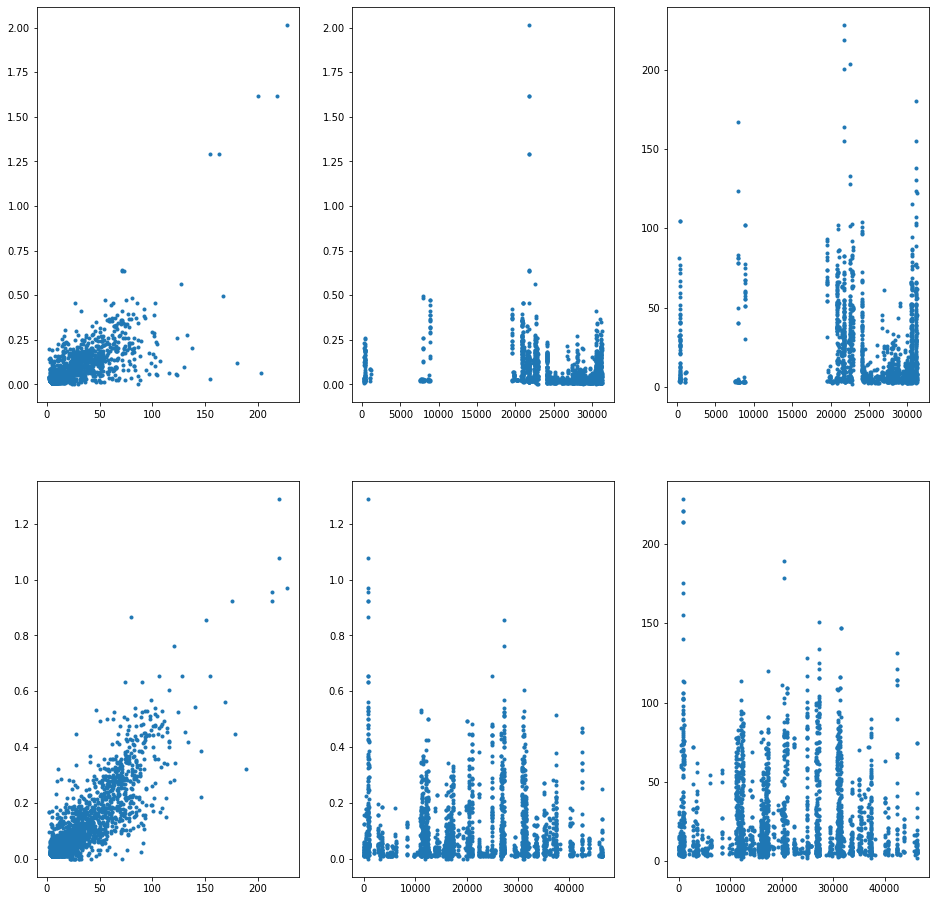

In [6]:
fig = plt.figure(figsize = (16,16))
i = 1
for df in dfs:
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.gyrTotal,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.gyrTotal,'.')
    i+=1


## Moving Average Method

In [87]:
df_train = dfs[1].reset_index()
df_test = dfs[0].reset_index()

df_train.date = pd.to_datetime(df_train.date)
df_test.date = pd.to_datetime(df_test.date)
df_train = seasonality(df_train,seasonality = 'month').find_seasonal_trends()
df_test = seasonality(df_test,seasonality = 'month').find_seasonal_trends()

In [19]:
df_train.head()

,index,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal,seasonality_month,times
0,0,2020-09-13 17:09:25,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784,9,61765.0
1,1,2020-09-13 17:09:26,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784,9,61766.0
2,2,2020-09-13 17:09:27,0.01,0.01,0.00,7.43,6.82,10.10,1,0.014142,14.273307,9,61767.0
3,12,2020-09-13 17:09:34,0.01,0.01,0.00,6.64,7.07,12.45,1,0.014142,15.782173,9,61774.0
4,13,2020-09-13 17:09:34,0.01,0.01,0.00,4.12,3.61,5.81,1,0.014142,7.985149,9,61774.0


In [20]:
df_test.head()

# seasonality class not working too well...

,index,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal,seasonality_month,times
0,220,2020-09-14 19:19:26,0.01,0.02,0.00,3.62,1.04,1.38,1,0.022361,4.011284,9,69566.0
1,319,2020-09-14 19:20:39,0.09,0.16,0.14,36.11,25.84,67.85,1,0.230868,81.087978,9,69639.0
2,320,2020-09-14 19:20:40,0.09,0.16,0.09,22.98,15.43,16.45,1,0.204450,32.198879,9,69640.0
3,321,2020-09-14 19:20:41,0.05,0.07,0.09,22.98,15.43,16.45,1,0.124499,32.198879,9,69641.0
4,322,2020-09-14 19:20:42,0.12,0.07,0.07,29.44,39.83,27.27,1,0.155563,56.540210,9,69642.0


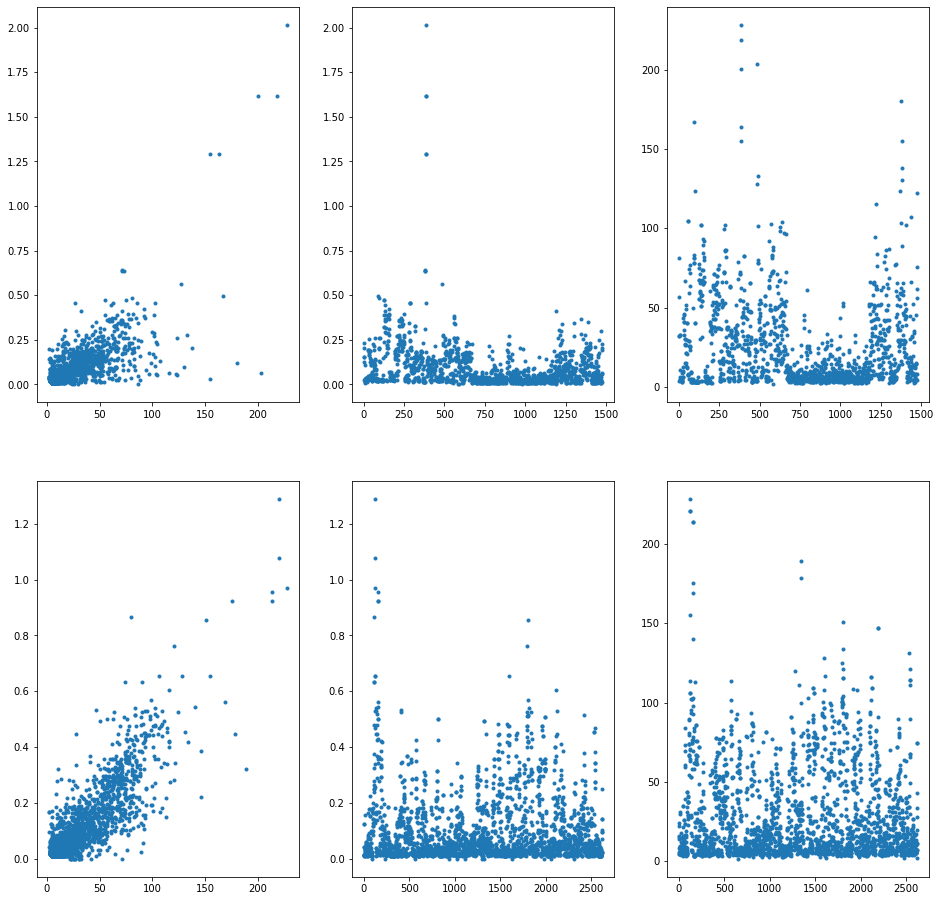

In [22]:
dfs = [df_test,df_train]

fig = plt.figure(figsize = (16,16))
i = 1
for df in dfs:
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.gyrTotal,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.gyrTotal,'.')
    i+=1



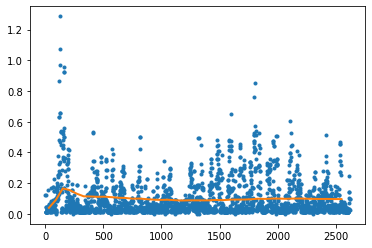

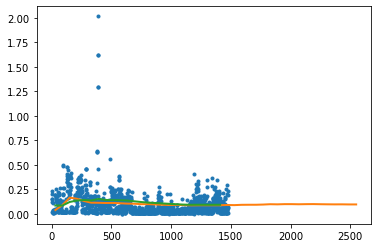

In [112]:
time_window = 1 # this is the number of hours for the moving average time window
time_index = time_window*60 # note that each index represents a 'second' of registered movements. So it doesn't actually have a 
# physical meaning

count = time_index
averages = []
x = []
while count < df_train.shape[0]:
    df_temp = df_train.iloc[:count]
    averages.append([df_temp.accTotal.mean(),df_temp.gyrTotal.mean()])
    x.append(count-time_index/2)


    count+= time_index
    #print(count,df_train.shape[0])

averages = np.asarray(averages).reshape(-2,2)

plt.plot(df_train.index,df_train.accTotal,'.')
plt.plot(x,averages[:,0],linewidth = 2)

plt.show()

plt.plot(df_test.index,df_test.accTotal,'.')
plt.plot(x,averages[:,0],linewidth = 2)

count = time_index
averages = []
x = []
while count < df_test.shape[0]:
    df_temp = df_test.iloc[:count]
    averages.append([df_temp.accTotal.mean(),df_temp.gyrTotal.mean()])
    x.append(count-time_index/2)


    count+= time_index
    #print(count,df_train.shape[0])
averages = np.asarray(averages).reshape(-2,2)

  
plt.plot(x,averages[:,0],linewidth = 2)


# based on primitive testing, the average method does NOT seem suitable here...
# I believe this is because of how right skewed the data is... Not sure I like this method at all...


In [109]:
class moving_avg:
    def __init__(self,df,time_window = 2):
        pass

# not convinced of this method? You can't even measure hours because the data that you have is less than 1 hr rn..

        

## Power of the singal

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/Users/yousefnami/python_environments/KinKeepers_AI/

/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/
['adjusting-seating-position', 'falling', 'crossing-arms', 'walking', 'crossing-legs', 'fetching-remote', 'sitting-down', 'lifting-leg', 'lying-down']


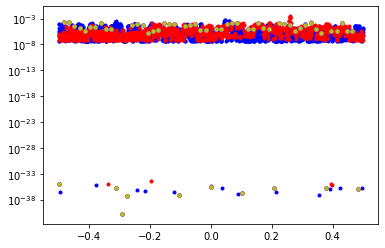

In [105]:
from scipy import signal

fs = 1 # sampling frequency
x = df_train.accTotal
x = ifft(x)
f, Pxx_den = signal.periodogram(x, fs) 
plt.show()

plt.semilogy(f, Pxx_den,'b.')

x = df_test.accTotal
x = ifft(x)
f, Pxx_den = signal.periodogram(x, fs) 

plt.semilogy(f, Pxx_den,'r.')
#plt.show()

# this shows some more promise... 
# at least very large movements can be captured


path = ['/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/']

df_testing, files = directory_to_df(path, ignore_index = False)
columns = df_testing.columns.values.tolist()
columns.remove('date')
df_testing.drop('gyrZ',inplace = True, axis = 1)
df_testing.columns = columns
df_testing['accTotal'] = np.sqrt(np.power(df_testing[['accX','accY','accZ']],2).sum(axis = 1))
df_testing['gyrTotal'] = np.sqrt(np.power(df_testing[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
df_testing.reset_index(inplace = True)

for file in df_testing.files.unique():
    x = df_testing.accTotal[df_testing.files == 9]
    x = ifft(x)
    f, Pxx_den = signal.periodogram(x, fs) 
    plt.semilogy(f, Pxx_den,'.')
print(files)


# not convinced if power works either...
# need to look into what the power function is actually doing ?

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


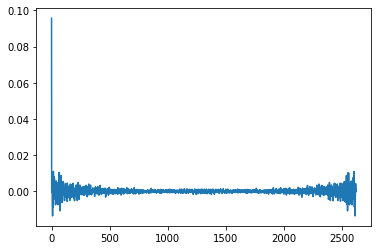

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


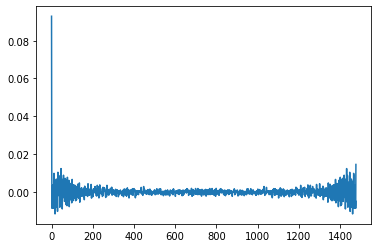

In [70]:
x = df_train.accTotal
x = ifft(x)
plt.plot(df_train.index,x)
plt.show()
x = df_test.accTotal
x = ifft(x)
plt.plot(df_test.index,x)

## 1. Detecting when movements are smaller 'on average'

Definition:
The solution to this detect movements that are smaller on average for a pre-defined time window (i.e. like a moving average). So every 5 hours, a moving average is taken, and if it has a lower threshold then an alarm is triggered.

Ideas:
1. Energy of a signal for every 5 hours
2. A moving average

## 2. Adapt to the fact that the seniors movements will be decreasing, on average, as a function of time

Definition:


Ideas:
- can you use Fluid Mechanics (Turbulence) ideas? On how statistically stationary your movements are? Do you need more data on this?

## 3. Detecting if there is an 'overall' decrease in daily activity (as measured totally by how many naps there are, how strong the movements are)

Definition:
Movements are defined on 

Ideas:
- can you convert gyration and acceleration into an 'energy' parameter and count it?

## 4. Detecting if there are large 'gaps' in data (i.e. long naps) or if there are spikes in continuous large movements

Definition:
Movements are defined on 

## 5. Detect irregular movements

# Conclusion

Having discussed this with the team, it seems that Problem 1, 3 are the most important